In [96]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit

import matplotlib
from matplotlib import pyplot as plt
import os
import sys


import networkx as nx
from tqdm import tqdm

In [2]:
import model
import train

---

# Copy Task

## Problem

Given a repeating sequence of distinct tokens, continue the pattern. This equates to learning an induction head.

## Dataset Generation

The dataset consists of sequences of varying length that contain a repeating pattern and cut-off abruptly. The goal is to continue the sequence correctly. There is no semantic meaning behind tokens, so they can be randomly generated at init and frozen.

E.g. abcabcabca should be continued with bcabcabc

### Base case

The most simple case will simply have 64-character strings containing repeating character sequences of 4 to 15 distinct characters, so we see 8 to 4 repetitions. To start we can use 32 distinct tokens.

In [3]:
# # create dataset; we need to add masking on the loss function!
# key_d1 = jax.random.PRNGKey(0)

# dataset_name = 'copytask'
# token_arr = jnp.arange(128, dtype=jnp.uint16)
# sample_len = 64
# n_data = 2**19*3
# patt_min = 4
# patt_max = 15
# assert sample_len >= patt_max # so there is at least one repetition
# assert patt_max >= patt_min
# assert n_data % (patt_max-patt_min+1) == 0 # so each pattern length is represented equally

# pattern_inds = []
# masks = []
# for patt_len in range(patt_min, patt_max+1):
#   p = jnp.tile(jnp.arange(patt_len), 1+sample_len//patt_len)[:sample_len]
#   pattern_inds.append(p)
#   m = jnp.ones(sample_len)
#   m = m.at[:patt_len].set(0)
#   masks.append(m)
# pattern_inds = jnp.array(pattern_inds)
# masks = jnp.array(masks)

# key_gen, key_shuffle = jax.random.split(key_d1)
# key_perms = jax.random.split(key_gen, n_data)

# tok_permutations = vmap(lambda k : jax.random.permutation(k, token_arr))(key_perms)
# pattern_inds_expanded = jnp.tile(pattern_inds, (n_data//len(pattern_inds), 1))
# masks_expanded = jnp.tile(masks, (n_data//len(masks), 1))

# data = vmap(lambda i : tok_permutations[i][pattern_inds_expanded[i]])(jnp.arange(n_data))
# data_shuffled = data[jax.random.permutation(key_shuffle, jnp.arange(n_data))] # shuffle the data
# masks_shuffled = masks_expanded[jax.random.permutation(key_shuffle, jnp.arange(n_data))]
# print(pattern_inds.shape, pattern_inds_expanded.shape, masks_expanded.shape, data.shape)
# data_with_mask = jnp.concatenate([data_shuffled[None, ...], masks_shuffled[None, ...]], axis=0)
# print(data_with_mask.shape)
# val_data_len = n_data//16
# train_ids = np.array(data_with_mask, dtype=np.uint16)[:, :-val_data_len, :].reshape(2, -1)
# val_ids = np.array(data_with_mask, dtype=np.uint16)[:, -val_data_len:, :].reshape(2, -1)
# try:
#   os.mkdir(dataset_name)
# except:
#   print(f'dataset {dataset_name} already exists')
# train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
# val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

# sample_len, n_data, val_data_len

In [4]:
# create dataset; we need to add masking on the loss function!
key_d1 = jax.random.PRNGKey(0)

dataset_name = 'copytask'
token_arr = jnp.arange(64, dtype=jnp.uint16)
sample_len = 64
n_data = 2**19*3
patt_min = 4
patt_max = 27
assert sample_len >= patt_max # so there is at least one repetition
assert patt_max >= patt_min
assert n_data % (patt_max-patt_min+1) == 0 # so each pattern length is represented equally

tok_special = token_arr[:2] # ensure these always map to inds 0
tok_ptr = token_arr[2:] # these are exchangeable, no semantic meaning
assert len(tok_ptr) >= patt_max

sample_inds = []
masks = []
for patt_len in range(patt_min, patt_max+1):
  pattern_inds = jnp.concatenate([jnp.array([1]), jnp.arange(len(tok_special), patt_len+len(tok_special))])
  p = jnp.tile(pattern_inds, 1+sample_len//patt_len)[:sample_len]
  p = p.at[0].set(0)
  sample_inds.append(p)
  m = jnp.ones_like(p)
  m = m.at[:len(pattern_inds) + 1].set(0) # mask the pattern and following 1 token
  # mask the last token of each copied pattern since we can assume it's the goal
  m = m.at[len(pattern_inds)::len(pattern_inds)].set(0)
  masks.append(m)
sample_inds = jnp.array(sample_inds)
masks = jnp.array(masks)

key_gen, key_shuffle = jax.random.split(key_d1)
key_perms = jax.random.split(key_gen, n_data)

# If sequences are permutations, the problem is easier: learn to map from the previous token to the current token in the input pattern
# tok_permutations = vmap(lambda k : jnp.concatenate([tok_special, jax.random.permutation(k, tok_ptr)]))(key_perms)
# If sequences are random choices, the problem is harder: learn to map several previous tokens to the current token in the input pattern
tok_permutations = vmap(lambda k : jnp.concatenate([tok_special, jax.random.choice(k, tok_ptr, shape=tok_ptr.shape)]))(key_perms)
pattern_inds_expanded = jnp.tile(sample_inds, (n_data//len(sample_inds), 1))
masks_expanded = jnp.tile(masks, (n_data//len(masks), 1))

data = vmap(lambda i : tok_permutations[i][pattern_inds_expanded[i]])(jnp.arange(n_data))
data_shuffled = data[jax.random.permutation(key_shuffle, jnp.arange(n_data))] # shuffle the data
masks_shuffled = masks_expanded[jax.random.permutation(key_shuffle, jnp.arange(n_data))]
data_with_mask = jnp.concatenate([data_shuffled[None, ...], masks_shuffled[None, ...]], axis=0)
val_data_len = n_data//16
train_ids = np.array(data_with_mask, dtype=np.uint16)[:, :-val_data_len, :].reshape(2, -1)
val_ids = np.array(data_with_mask, dtype=np.uint16)[:, -val_data_len:, :].reshape(2, -1)
try:
  os.mkdir(dataset_name)
except:
  print(f'dataset {dataset_name} already exists')
train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

sample_len, n_data, val_data_len, train_ids.shape, val_ids.shape

dataset copytask already exists


(64, 1572864, 98304, (2, 94371840), (2, 6291456))

In [5]:
i = 0
train_ids[0][i*sample_len:(i+1)*sample_len], train_ids[1][i*sample_len:(i+1)*sample_len]

(array([ 0,  2, 47, 33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27,  1,
         2, 47, 33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27,  1,  2,
        47, 33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27,  1,  2, 47,
        33, 56, 50, 17, 27,  1,  2, 47, 33, 56, 50, 17, 27], dtype=uint16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       dtype=uint16))

In [6]:
# !rm -rf /content/logs

In [7]:
# %%capture
config = train.TrainConfig(
    input_bin=f"{dataset_name}/train_with_mask.bin",
    input_val_bin=f"{dataset_name}/val_with_mask.bin",
    embd_dim = 128,
    head_dim = 64,
    n_layer = 2,
    block_size = 2*sample_len, # should match the task sequence length so tasks are independently trained on
    batch_size = 64,
    gradient_accumulation_steps = 1,
    max_iters = 25_000,
    eval_iters = 25, # val_data_len // 64, # number of examples // batch_size
    learning_rate = 1e-2,
    min_lr = 1e-5,
    warmup_iters = 500,
    lr_decay_iters = 20_000,
    vocab_size = len(token_arr),
    use_masked_loss = True,
    use_mlp = False,
    off_by_one_attn = False,
    use_pope = True,
    # freeze_params=("wte",),
    max_seq_len = 6*sample_len,

    pos_encoding_base = 1_000,
    
    log_interval = 10_000,
    eval_interval = 1_000,
)
display(config)

TrainConfig(mesh_axis_names=('dp',), mesh_shape=(4,), input_bin='copytask/train_with_mask.bin', input_val_bin='copytask/val_with_mask.bin', wandb_project='gpt-jax', wandb_entity=None, wandb_run_name=None, wandb_group=None, wandb_job_type=None, wandb_tags=(), wandb_notes=None, wandb_mode='online', wandb_log_code=True, max_iters=25000, warmup_iters=500, lr_decay_iters=20000, eval_interval=1000, eval_iters=25, log_interval=10000, save_every=0, batch_size=64, gradient_accumulation_steps=1, learning_rate=0.01, min_lr=1e-05, weight_decay=0.1, beta1=0.9, beta2=0.95, grad_clip=1.0, n_layer=2, embd_dim=128, head_dim=64, block_size=128, vocab_size=64, dropout=0.0, max_seq_len=384, pos_encoding_base=1000, use_mlp=False, off_by_one_attn=False, use_pope=True, seed=1337, use_masked_loss=True, freeze_params=())

In [8]:
params = train.train_loop(config)

[wandb] No credentials found. Falling back to offline mode.


wandb: Number of parameters: 0.14M
wandb: No parameter freezing applied
wandb: Loading training data...
wandb: Process 0/1 prepared dataset from 1 file(s): 94,371,840 tokens, 0.38 GB on disk.
wandb: Process 0/1 prepared loader with 25000 batches.
wandb: Loaded 25000 training batches.
wandb: Loading validation data...
wandb: Process 0/1 prepared dataset from 1 file(s): 6,291,456 tokens, 0.03 GB on disk.
wandb: Process 0/1 prepared loader with 25 batches.
wandb: Loaded 25 validation batches.
wandb: Starting Ahead-of-Time (AOT) compilation...


Number of parameters: 0.14M
No parameter freezing applied
Loading training data...
Process 0/1 prepared dataset from 1 file(s): 94,371,840 tokens, 0.38 GB on disk.
Process 0/1 prepared loader with 25000 batches.
Loaded 25000 training batches.
Loading validation data...
Process 0/1 prepared dataset from 1 file(s): 6,291,456 tokens, 0.03 GB on disk.
Process 0/1 prepared loader with 25 batches.
Loaded 25 validation batches.
Starting Ahead-of-Time (AOT) compilation...


wandb: AOT compilation finished.
wandb: Starting training...
wandb: Running validation for step 0...


AOT compilation finished.
Starting training...
Running validation for step 0...
model/total_params: 139392 | model/attn_params: 131072 | model/mlp_params: 0 | model/embed_params: 8192 | model/vocab_size: 64 | val_loss: 4.265 | step: 0 | lr: 0 | loss: 4.27


wandb: Running validation for step 1000...


Running validation for step 1000...
val_loss: 2.827


wandb: Running validation for step 2000...


Running validation for step 2000...
val_loss: 2.798


wandb: Running validation for step 3000...


Running validation for step 3000...
val_loss: 2.622


wandb: Running validation for step 4000...


Running validation for step 4000...
val_loss: 2.233


wandb: Running validation for step 5000...


Running validation for step 5000...
val_loss: 2.177


wandb: Running validation for step 6000...


Running validation for step 6000...
val_loss: 0.8845


wandb: Running validation for step 7000...


Running validation for step 7000...
val_loss: 0.2662


wandb: Running validation for step 8000...


Running validation for step 8000...
val_loss: 0.0267


wandb: Running validation for step 9000...


Running validation for step 9000...
val_loss: 0.01225


wandb: Running validation for step 10000...


Running validation for step 10000...
val_loss: 0.01532 | step: 10000 | lr: 0.005206 | loss: 0.01168


wandb: Running validation for step 11000...


Running validation for step 11000...
val_loss: 0.0064


wandb: Cycling dataset...


Cycling dataset...


wandb: Running validation for step 12000...


Running validation for step 12000...
val_loss: 0.009721


wandb: Running validation for step 13000...


Running validation for step 13000...
val_loss: 0.003326


wandb: Running validation for step 14000...


Running validation for step 14000...
val_loss: 0.002136


wandb: Running validation for step 15000...


Running validation for step 15000...
val_loss: 0.001865


wandb: Running validation for step 16000...


Running validation for step 16000...
val_loss: 0.00101


wandb: Running validation for step 17000...


Running validation for step 17000...
val_loss: 0.0004495


wandb: Running validation for step 18000...


Running validation for step 18000...
val_loss: 0.0001743


wandb: Running validation for step 19000...


Running validation for step 19000...
val_loss: 0.0001071


wandb: Running validation for step 20000...


Running validation for step 20000...
val_loss: 9e-05 | step: 20000 | lr: 1e-05 | loss: 0.0001249


wandb: Running validation for step 21000...


Running validation for step 21000...
val_loss: 9.534e-05


wandb: Running validation for step 22000...


Running validation for step 22000...
val_loss: 0.0001139


wandb: Running validation for step 23000...
wandb: Cycling dataset...


Running validation for step 23000...
val_loss: 9.885e-05
Cycling dataset...


wandb: Running validation for step 24000...


Running validation for step 24000...
val_loss: 0.0001076


wandb: Final validation...
wandb: Running validation for step 24999...
wandb: Training finished.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: Saved checkpoint to logs/f3ljktln//state_step024999.pkl


Final validation...
Running validation for step 24999...
step: 24999 | val_loss: 9.652e-05
Training finished.
Saved checkpoint to logs/f3ljktln//state_step024999.pkl


loss,█▁▁
lr,▁█▁
model/attn_params,▁
model/embed_params,▁
model/mlp_params,▁
model/total_params,▁
model/vocab_size,▁
step,▁▄▇█
val_loss,██▇▇▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00012
lr,1e-05


In [9]:
test_input = jnp.array([0]+[2,3,4,5,6,7,8,9], dtype=jnp.uint16)
patt_len = len(test_input)
print('patt_len', patt_len)
res = jnp.zeros(config.max_seq_len, dtype=jnp.uint16)
res = res.at[:patt_len].set(test_input).at[patt_len].set(1)

rope_params = model.precompute_pope(config.get_model_config(), None) if config.use_pope else model.precompute_rope(config.get_model_config(), None)
for i in tqdm(range(patt_len, len(res))):
  preds = model.gpt_forward(params, rope_params, res[None,:], config.get_model_config())
  new_ind = jnp.argmax(preds[0][i])
  res = res.at[i+1].set(new_ind if ((i+1) % patt_len > 0) else 1)

preds, attn_weights = model.gpt_forward(params, rope_params, res[None,:], config.get_model_config(), return_attn_weights=True)

patt_len 9


  0%|          | 0/375 [00:00<?, ?it/s]

/home/nikola.georgiev2000/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 375/375 [00:07<00:00, 52.12it/s]


In [10]:
def heatmap(data, row_labels, col_labels, ax=None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=0, ha="right", rotation_mode="anchor", fontsize=6)
    ax.set_yticks(range(data.shape[0]), labels=row_labels, fontsize=6)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    for ticklabel in ax.get_yticklabels():
        ticklabel.set_horizontalalignment("right")
    for ticklabel in ax.get_xticklabels():
        ticklabel.set_horizontalalignment("center")

    

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

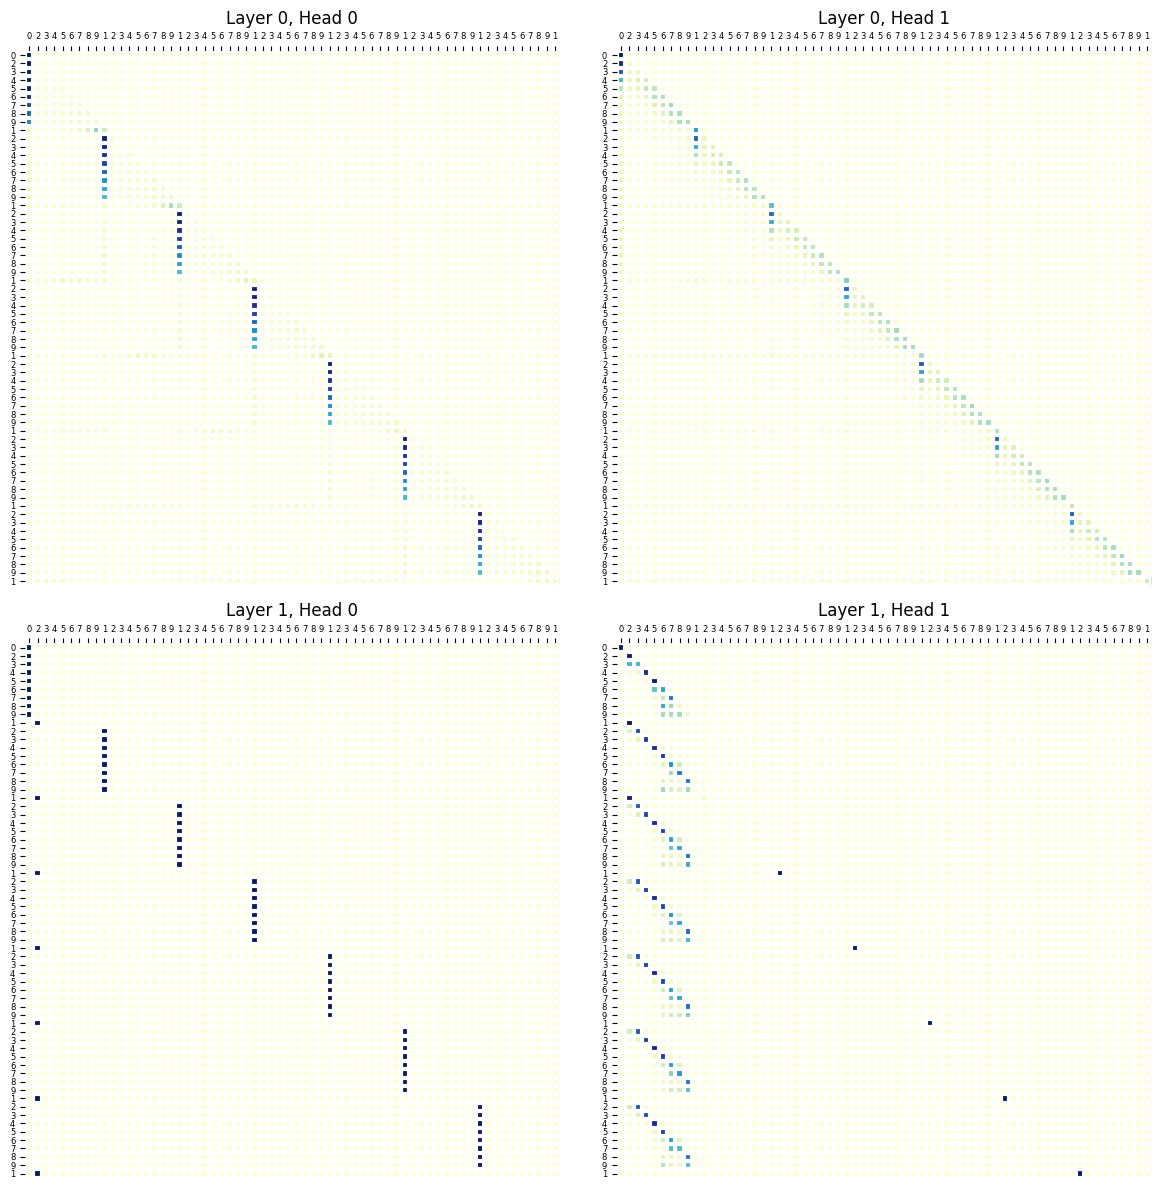

In [11]:
subset = jnp.arange(0, 1*sample_len)

# Determine num_layers and num_heads from attn_weights structure
num_layers = len(attn_weights)
num_heads = attn_weights[0][0].shape[0]  # Assuming shape: [num_heads, seq, seq]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(6 * num_heads, 6 * num_layers), squeeze=False)

for l in range(num_layers):
    for h in range(num_heads):
        selected_attn = attn_weights[l][0][h][subset[:, None], subset[None, :]]
        ax = axes[l, h]
        im = heatmap(
            selected_attn,
            res[subset], res[subset], ax=ax,
            cmap="YlGnBu"
        )
        ax.set_title(f"Layer {l}, Head {h}")

fig.tight_layout()
plt.show()

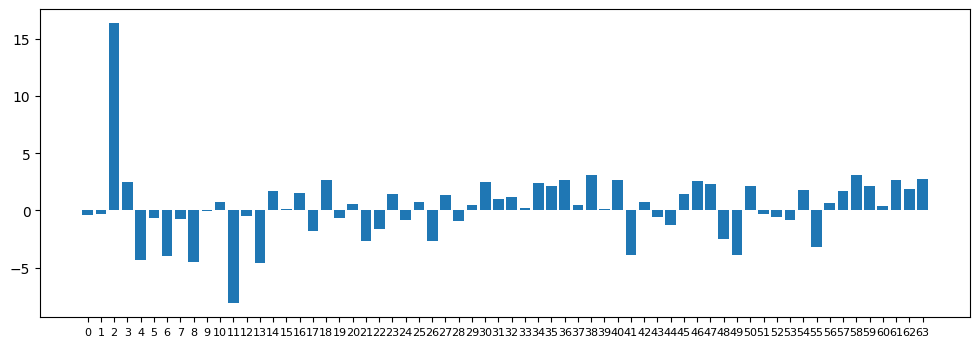

In [12]:
plt.figure(figsize=(12, 4))
plt.bar(jnp.arange(preds.shape[-1]), preds[0][patt_len])
plt.xticks(jnp.arange(preds.shape[-1]), token_arr, rotation=0, fontsize=8)
plt.show()

In [13]:
res = jnp.array(res)

print("Testing input:")
print(f'{0:2d}: {test_input}')

print("Predicted output:")
for i, l in enumerate(res[patt_len: len(res) - (len(res)%patt_len)].reshape(-1, patt_len)):
    # format so index strings are aligned
    print(f'{i+1:2d}: {l} - {"✅" if (l - test_input).sum() == 1 else "❌"}')

Testing input:
 0: [0 2 3 4 5 6 7 8 9]
Predicted output:
 1: [1 2 3 4 5 6 7 8 9] - ✅
 2: [1 2 3 4 5 6 7 8 9] - ✅
 3: [1 2 3 4 5 6 7 8 9] - ✅
 4: [1 2 3 4 5 6 7 8 9] - ✅
 5: [1 2 3 4 5 6 7 8 9] - ✅
 6: [1 2 3 4 5 6 7 8 9] - ✅
 7: [1 2 3 4 5 6 7 8 9] - ✅
 8: [1 2 2 2 2 2 2 2 2] - ❌
 9: [1 2 2 2 2 2 2 2 2] - ❌
10: [1 2 2 2 2 2 2 2 2] - ❌
11: [1 2 2 2 2 2 2 2 2] - ❌
12: [1 2 2 2 2 2 2 2 2] - ❌
13: [1 2 2 2 2 2 2 2 2] - ❌
14: [1 2 2 2 2 2 2 2 2] - ❌
15: [1 2 2 2 2 2 2 2 2] - ❌
16: [1 2 2 2 2 2 2 2 2] - ❌
17: [1 2 2 2 2 2 2 2 2] - ❌
18: [1 2 2 2 2 2 2 2 2] - ❌
19: [1 2 2 2 2 2 2 2 2] - ❌
20: [1 2 2 2 2 2 2 2 2] - ❌
21: [1 2 2 2 2 2 2 2 2] - ❌
22: [1 2 2 2 2 2 2 2 2] - ❌
23: [1 2 2 2 2 2 2 2 2] - ❌
24: [1 2 2 2 2 2 2 2 2] - ❌
25: [1 2 2 2 2 2 2 2 2] - ❌
26: [1 2 2 2 2 2 2 2 2] - ❌
27: [1 2 2 2 2 2 2 2 2] - ❌
28: [1 2 2 2 2 2 2 2 2] - ❌
29: [1 2 2 2 2 2 2 2 2] - ❌
30: [1 2 2 2 2 2 2 2 2] - ❌
31: [1 2 2 2 2 2 2 2 2] - ❌
32: [1 2 2 2 2 2 2 2 2] - ❌
33: [1 2 2 2 2 2 2 2 2] - ❌
34: [1 2 2 2 2 2 2 

### QUESTION

What's the better way to encode the Copy Task for generalizing to longer sequences?

1. End all patterns with the special token (0). A possible algorithm to learn is to check if there is a 0 in context and if not, record the previous token. If yes, just query and copy based on context. If we don't use off-by-one attention, the first token will likely be a sink token, which might hurt performance.
2. Start patterns with special tokens, 0 for the input and 1 for outputs (copied from the input). This will likely result in a sink token at the first position.


### TODO

Add a better long-context Copy Task dataset with many examples to properly test generalization.
Do a sweep over learning rates, embedding sizes, number of attention heads, number of layers.

Should I try a different position encoding? Seems like the model struggles to learn the n-grams need copying.

---

# Variable Assignment

## Problem

Have the ability to assign values to variables and retrieve them.

## Dataset Generation

Special tokens for denote load/store operations, variable names, and the end of an operation.

These operations are sampled independently and randomly, so the model must learn to store and retrieve variables. Assume a load operation is always preceded by a store operation for the same variable.

The loss for the inputs is not counted, i.e. special tokens and values in store operations, since these are not predictable. For this we will need to create a mask array in addition to the sample data.

Variation in value lengths and number of operations is important for generalization.

### Sequence formats

*Store*
- [ STORE=0, VAR∈{3..7}, value_tokens..., END=2 ]

*Load*
- [ LOAD=1, VAR∈{3..7}, retrieved_value_tokens..., END=2 ]

Loss mask = 1 for retrieved_value_tokens only.

Loss mask = 0 for value_tokens, LOAD, VAR, END.

This makes the task “learn to remember values and output them when asked.”

#### Tokenization

Overall will use 64 tokens, where non-special tokens are exchangeable.

Special Tokens (with index):
- Store op: 0
- Load op: 1
- End of operation: 2
- Variable names: 3-7 (5 total)



In [14]:
import psutil

print(f'Number of physical cores: {psutil.cpu_count(logical=True)}')

Number of physical cores: 180


In [15]:
import numpy as np
from numba import njit, prange

STORE = 0
LOAD  = 1
END   = 2

TOK_COUNT = 64
VAR_MIN, VAR_MAX = 3, 7
VAL_MIN, VAL_MAX_EXCL = 8, 64  # [8, 64)

@njit(inline="always")
def splitmix64(x):
    x = (x + np.uint64(0x9E3779B97F4A7C15)) & np.uint64(0xFFFFFFFFFFFFFFFF)
    z = x
    z = (z ^ (z >> np.uint64(30))) * np.uint64(0xBF58476D1CE4E5B9) & np.uint64(0xFFFFFFFFFFFFFFFF)
    z = (z ^ (z >> np.uint64(27))) * np.uint64(0x94D049BB133111EB) & np.uint64(0xFFFFFFFFFFFFFFFF)
    return z ^ (z >> np.uint64(31))

@njit(inline="always")
def xorshift64star(state):
    x = state
    x ^= (x >> np.uint64(12))
    x ^= (x << np.uint64(25)) & np.uint64(0xFFFFFFFFFFFFFFFF)
    x ^= (x >> np.uint64(27))
    state = x
    return (x * np.uint64(0x2545F4914F6CDD1D)) & np.uint64(0xFFFFFFFFFFFFFFFF), state

@njit(inline="always")
def rand_u32(state):
    r, state = xorshift64star(state)
    return np.uint32(r & np.uint64(0xFFFFFFFF)), state

@njit(inline="always")
def rand_int_inclusive(state, lo, hi):
    r, state = rand_u32(state)
    span = hi - lo + 1
    return lo + int(r % np.uint32(span)), state

@njit(inline="always")
def rand_float01(state):
    r, state = xorshift64star(state)
    return (r >> np.uint64(11)) * (1.0 / (1 << 53)), state


@njit(parallel=True)
def generate_batch_numba_partial_ops(
    batch_size: int,
    seq_len: int,
    base_seed: int,
    min_value_len: int,
    max_value_len: int,
    p_load: float,
):
    """
    Returns:
      tokens: uint16 [B, L]
      loss_mask: uint8 [B, L]  (1 only on retrieved value tokens in LOAD ops)
    Behavior at end:
      If an op doesn't fully fit, we write as much of it as we can and stop
      (op may be missing tail and/or END).
    """
    tokens = np.empty((batch_size, seq_len), dtype=np.uint16)
    mask   = np.zeros((batch_size, seq_len), dtype=np.uint8)

    for b in prange(batch_size):
        s = splitmix64(np.uint64(base_seed + b + 1))

        last_val = np.empty((5, max_value_len), dtype=np.uint16)
        last_len = np.zeros(5, dtype=np.int32)
        stored   = np.zeros(5, dtype=np.uint8)

        p = 0
        while p < seq_len:
            v, s = rand_int_inclusive(s, VAR_MIN, VAR_MAX)
            vi = v - VAR_MIN

            u, s = rand_float01(s)
            want_load = (u < p_load) and (stored[vi] == 1)

            if want_load:
                n = int(last_len[vi])

                # Write prefix: LOAD, VAR
                if p < seq_len:
                    tokens[b, p] = LOAD
                    p += 1
                else:
                    break
                if p < seq_len:
                    tokens[b, p] = np.uint16(v)
                    p += 1
                else:
                    break

                # Write retrieved values (mask=1)
                for i in range(n):
                    if p >= seq_len:
                        break
                    tokens[b, p] = last_val[vi, i]
                    mask[b, p] = 1
                    p += 1

                # Write END if it fits
                if p < seq_len:
                    tokens[b, p] = END
                    mask[b, p] = 1 # Also trigger loss on LOAD op END
                    p += 1
                else:
                    break

            else:
                # STORE: sample value length
                n, s = rand_int_inclusive(s, min_value_len, max_value_len)

                # Sample value tokens (also update last_val/last_len even if op truncates)
                for i in range(n):
                    t, s = rand_int_inclusive(s, VAL_MIN, VAL_MAX_EXCL - 1)
                    last_val[vi, i] = np.uint16(t)
                last_len[vi] = n
                stored[vi] = 1

                # Write prefix: STORE, VAR
                if p < seq_len:
                    tokens[b, p] = STORE
                    p += 1
                else:
                    break
                if p < seq_len:
                    tokens[b, p] = np.uint16(v)
                    p += 1
                else:
                    break

                # Write value tokens (mask stays 0)
                for i in range(n):
                    if p >= seq_len:
                        break
                    tokens[b, p] = last_val[vi, i]
                    p += 1

                # Write END if it fits
                if p < seq_len:
                    tokens[b, p] = END
                    p += 1
                else:
                    break

    return tokens, mask


In [16]:
dataset_name = 'loadtask'

n_data = 2**19*3
sample_len = 512
val_data_len = n_data//16
data, mask = generate_batch_numba_partial_ops(n_data, sample_len, 0, 4, 32, 0.8)
data_with_mask = np.concatenate([data[None, ...], mask[None, ...]], axis=0)
train_ids = data_with_mask[:, :-val_data_len, :].reshape(2, -1)
val_ids = data_with_mask[:, -val_data_len:, :].reshape(2, -1)

if not os.path.exists(dataset_name):
    os.makedirs(dataset_name)
train_ids.tofile(os.path.join(dataset_name, 'train_with_mask.bin'))
val_ids.tofile(os.path.join(dataset_name, 'val_with_mask.bin'))

print(f'Active tokens: {val_ids[1].mean() * 100:.2f}%')

Active tokens: 56.96%


In [17]:
# %%capture
config = train.TrainConfig(
    input_bin=f"{dataset_name}/train_with_mask.bin",
    input_val_bin=f"{dataset_name}/val_with_mask.bin",
    embd_dim = 128,
    head_dim = 64,
    n_layer = 2,
    block_size = sample_len, # should match the task sequence length so tasks are independently trained on
    batch_size = 64,
    gradient_accumulation_steps = 2,
    max_iters = 25_000,
    eval_iters = 25, # val_data_len // 64, # number of examples // batch_size
    learning_rate = 1e-2,
    min_lr = 1e-5,
    warmup_iters = 500,
    lr_decay_iters = 20_000,
    vocab_size = TOK_COUNT,
    use_masked_loss = True,
    use_mlp = False,
    off_by_one_attn = False,
    use_pope = True,
    # freeze_params=("wte",),
    max_seq_len = 2*sample_len,

    pos_encoding_base = 10*sample_len,
    
    log_interval = 10_000,
    eval_interval = 1_000,
)
display(config)

TrainConfig(mesh_axis_names=('dp',), mesh_shape=(4,), input_bin='loadtask/train_with_mask.bin', input_val_bin='loadtask/val_with_mask.bin', wandb_project='gpt-jax', wandb_entity=None, wandb_run_name=None, wandb_group=None, wandb_job_type=None, wandb_tags=(), wandb_notes=None, wandb_mode='online', wandb_log_code=True, max_iters=25000, warmup_iters=500, lr_decay_iters=20000, eval_interval=1000, eval_iters=25, log_interval=10000, save_every=0, batch_size=64, gradient_accumulation_steps=2, learning_rate=0.01, min_lr=1e-05, weight_decay=0.1, beta1=0.9, beta2=0.95, grad_clip=1.0, n_layer=2, embd_dim=128, head_dim=64, block_size=512, vocab_size=64, dropout=0.0, max_seq_len=1024, pos_encoding_base=5120, use_mlp=False, off_by_one_attn=False, use_pope=True, seed=1337, use_masked_loss=True, freeze_params=())

In [18]:
val_ids[0, :sample_len//4] * val_ids[1, :sample_len//4]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 29, 38, 35, 13, 11, 34, 62, 22, 49, 23, 55, 16, 53, 54, 34,  2,
        0,  0, 29, 38, 35, 13, 11, 34, 62, 22, 49, 23, 55, 16, 53, 54, 34,
        2,  0,  0, 29, 38, 35, 13, 11, 34, 62, 22, 49, 23, 55, 16, 53, 54,
       34,  2,  0,  0, 57, 14, 17, 44, 23, 10, 10, 47, 57, 54, 42, 27,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint16)

In [19]:
params = train.train_loop(config)

[wandb] No credentials found. Falling back to offline mode.


wandb: Number of parameters: 0.14M
wandb: No parameter freezing applied
wandb: Loading training data...
wandb: Process 0/1 prepared dataset from 1 file(s): 754,974,720 tokens, 3.02 GB on disk.
wandb: Process 0/1 prepared loader with 25000 batches.
wandb: Loaded 25000 training batches.
wandb: Loading validation data...
wandb: Process 0/1 prepared dataset from 1 file(s): 50,331,648 tokens, 0.20 GB on disk.
wandb: Process 0/1 prepared loader with 25 batches.
wandb: Loaded 25 validation batches.
wandb: Starting Ahead-of-Time (AOT) compilation...


Number of parameters: 0.14M
No parameter freezing applied
Loading training data...
Process 0/1 prepared dataset from 1 file(s): 754,974,720 tokens, 3.02 GB on disk.
Process 0/1 prepared loader with 25000 batches.
Loaded 25000 training batches.
Loading validation data...
Process 0/1 prepared dataset from 1 file(s): 50,331,648 tokens, 0.20 GB on disk.
Process 0/1 prepared loader with 25 batches.
Loaded 25 validation batches.
Starting Ahead-of-Time (AOT) compilation...


wandb: AOT compilation finished.
wandb: Starting training...
wandb: Running validation for step 0...


AOT compilation finished.
Starting training...
Running validation for step 0...
model/total_params: 139392 | model/attn_params: 131072 | model/mlp_params: 0 | model/embed_params: 8192 | model/vocab_size: 64 | val_loss: 4.291 | step: 0 | lr: 0 | loss: 4.285


wandb: Running validation for step 1000...


Running validation for step 1000...
val_loss: 0.01549


wandb: Running validation for step 2000...


Running validation for step 2000...
val_loss: 0.007518


wandb: Running validation for step 3000...


Running validation for step 3000...
val_loss: 0.005813


wandb: Running validation for step 4000...


Running validation for step 4000...
val_loss: 0.0046


wandb: Running validation for step 5000...


Running validation for step 5000...
val_loss: 0.005457


wandb: Running validation for step 6000...


Running validation for step 6000...
val_loss: 0.003716


wandb: Running validation for step 7000...


Running validation for step 7000...
val_loss: 0.00472


wandb: Running validation for step 8000...


Running validation for step 8000...
val_loss: 0.00328


wandb: Running validation for step 9000...


Running validation for step 9000...
val_loss: 0.003163


wandb: Running validation for step 10000...


Running validation for step 10000...
val_loss: 0.002083 | step: 10000 | lr: 0.005206 | loss: 0.001861


wandb: Running validation for step 11000...


Running validation for step 11000...
val_loss: 0.00208


wandb: Cycling dataset...


Cycling dataset...


wandb: Running validation for step 12000...


Running validation for step 12000...
val_loss: 0.001473


wandb: Running validation for step 13000...


Running validation for step 13000...
val_loss: 0.0008955


wandb: Running validation for step 14000...


Running validation for step 14000...
val_loss: 0.001044


wandb: Running validation for step 15000...


Running validation for step 15000...
val_loss: 0.0004105


wandb: Running validation for step 16000...


Running validation for step 16000...
val_loss: 0.0002742


wandb: Running validation for step 17000...


Running validation for step 17000...
val_loss: 0.0001346


wandb: Running validation for step 18000...


Running validation for step 18000...
val_loss: 9.984e-05


wandb: Running validation for step 19000...


Running validation for step 19000...
val_loss: 6.024e-05


wandb: Running validation for step 20000...


Running validation for step 20000...
val_loss: 7.274e-05 | step: 20000 | lr: 1e-05 | loss: 5.53e-05


wandb: Running validation for step 21000...


Running validation for step 21000...
val_loss: 6.822e-05


wandb: Running validation for step 22000...


Running validation for step 22000...
val_loss: 6.635e-05


wandb: Running validation for step 23000...
wandb: Cycling dataset...


Running validation for step 23000...
val_loss: 7.228e-05
Cycling dataset...


wandb: Running validation for step 24000...


Running validation for step 24000...
val_loss: 6.718e-05


wandb: Final validation...
wandb: Running validation for step 24999...
wandb: Training finished.
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.
wandb: Saved checkpoint to logs/6u0lvfz6//state_step024999.pkl


Final validation...
Running validation for step 24999...
step: 24999 | val_loss: 6.11e-05
Training finished.
Saved checkpoint to logs/6u0lvfz6//state_step024999.pkl


loss,█▁▁
lr,▁█▁
model/attn_params,▁
model/embed_params,▁
model/mlp_params,▁
model/total_params,▁
model/vocab_size,▁
step,▁▄▇█
val_loss,█▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,6e-05
lr,1e-05


In [20]:
def _rand_values(rng: np.random.Generator, n: int):
    return rng.integers(VAL_MIN, VAL_MAX_EXCL, size=n, dtype=np.int32).tolist()


def run_scripted_ops(
    model,
    params,
    config,
    next_ops,
    *,
    max_len: int = 4096,
    max_gen_per_load: int = 256,
    seed: int = 0,
    return_attn_weights: bool = True,
):
    """
    next_ops format:
      - STORE op: [STORE, var, [value_tokens...]]  (END is appended automatically)
      - LOAD op:  [LOAD, var]                      (model generates value_tokens..., END)

    Returns:
      res: full token buffer (length max_len)
      cursor: first unused position in res
      load_generations: list of dicts with generated tokens per LOAD
      (preds, attn_weights) from a final forward pass over res
    """
    rng = np.random.default_rng(seed)

    # Precompute rope/pope params once
    rope_params = (
        model.precompute_pope(config.get_model_config(), None)
        if config.use_pope
        else model.precompute_rope(config.get_model_config(), None)
    )

    # Big fixed buffer (like you already do)
    res = jnp.zeros((max_len,), dtype=jnp.int32)
    cursor = 0

    load_generations = []

    def write_tokens(buf, pos, toks):
        toks = jnp.asarray(toks, dtype=buf.dtype)
        n = toks.shape[0]
        return buf.at[pos:pos + n].set(toks), pos + n

    for op_idx, op in enumerate(next_ops):
        op_type = int(op[0])

        if op_type == STORE:
            var = int(op[1])
            value_tokens = op[2]

            # Allow caller to pass "random values..." placeholder as None
            if value_tokens is None:
                # Choose some length (you can parameterize this)
                value_tokens = _rand_values(rng, n=int(rng.integers(1, 9)))

            # Write: [STORE, var, value..., END]
            store_seq = [STORE, var] + list(value_tokens) + [END]
            res, cursor = write_tokens(res, cursor, store_seq)

        elif op_type == LOAD:
            var = int(op[1])

            # Write LOAD prefix: [LOAD, var]
            prefix_start = cursor
            res, cursor = write_tokens(res, cursor, [LOAD, var])

            # Now generate until END (or max_gen_per_load)
            generated = []
            ended = False
            for _ in range(max_gen_per_load):
                # Predict next token at position `cursor`
                # logits at index cursor-1 correspond to next-token distribution for cursor
                i = cursor - 1
                preds = model.gpt_forward(params, rope_params, res[None, :], config.get_model_config())
                new_tok = int(jnp.argmax(preds[0][i]))

                res = res.at[cursor].set(new_tok)
                cursor += 1

                if new_tok == END:
                    ended = True
                    break
                generated.append(new_tok)

                if cursor >= max_len:
                    break

            load_generations.append({
                "op_index": op_idx,
                "var": var,
                "prefix_span": (prefix_start, prefix_start + 2),
                "generated_value_tokens": generated,
                "ended_with_END": ended,
                "end_pos": cursor - 1 if ended else None,
            })

        else:
            raise ValueError(f"Unknown op type: {op_type}")

        if cursor >= max_len:
            break

    # Final forward pass if you want attention weights after the whole scripted run
    if return_attn_weights:
        preds, attn_weights = model.gpt_forward(
            params, rope_params, res[None, :], config.get_model_config(), return_attn_weights=True
        )
        return res, cursor, load_generations, preds, attn_weights
    else:
        preds = model.gpt_forward(params, rope_params, res[None, :], config.get_model_config())
        return res, cursor, load_generations, preds, None

In [21]:
rng = np.random.default_rng(0)
next_ops = [
    [STORE, 7, _rand_values(rng, 5)], 
    [STORE, 3, _rand_values(rng, 4)], 
    [STORE, 6, _rand_values(rng, 6)],
    [LOAD,  3],                       
    [STORE, 3, _rand_values(rng, 3)], 
    [LOAD,  7],
    [STORE, 6, _rand_values(rng, 4)],
    [LOAD,  6],
    [STORE, 4, _rand_values(rng, 20)],
    [STORE, 6, _rand_values(rng, 10)],
    [LOAD,  7],
    [LOAD,  6],
    [LOAD,  7],
    [LOAD,  6],
    [LOAD,  4],
    [LOAD,  3],
]
# next_ops = [
#     [STORE, 7, _rand_values(rng, 5)], 
#     [STORE, 6, _rand_values(rng, 6)],
#     [LOAD,  7],
#     [LOAD,  6],
# ]

res, cursor, load_gens, preds, attn_weights = run_scripted_ops(
    model, params, config, next_ops,
    max_len=1024,
    max_gen_per_load=128,
    seed=123,
)
print(f"cursor: {cursor}")
i = 0
for op in next_ops:
    if op[0] == STORE:
        print(f"STORE var={op[1]} -> {op[2]}")
    elif op[0] == LOAD:
        g = load_gens[i]
        print(f"LOAD var={g['var']} -> {g['generated_value_tokens']} (ended={g['ended_with_END']})")
        i += 1

cursor: 166
STORE var=7 -> [55, 43, 36, 23, 25]
STORE var=3 -> [10, 12, 8, 17]
STORE var=6 -> [53, 44, 59, 36, 41, 62]
LOAD var=3 -> [10, 12, 8, 17] (ended=True)
STORE var=3 -> [48, 43, 38]
LOAD var=7 -> [55, 43, 36, 23, 25] (ended=True)
STORE var=6 -> [39, 60, 23, 53]
LOAD var=6 -> [39, 60, 23, 53] (ended=True)
STORE var=4 -> [45, 8, 30, 56, 39, 9, 50, 48, 55, 17, 13, 56, 9, 38, 12, 24, 34, 31, 30, 9]
STORE var=6 -> [8, 14, 8, 45, 37, 44, 22, 42, 50, 29]
LOAD var=7 -> [55, 43, 36, 23, 25] (ended=True)
LOAD var=6 -> [8, 14, 8, 45, 37, 44, 22, 42, 50, 29] (ended=True)
LOAD var=7 -> [55, 43, 36, 23, 25] (ended=True)
LOAD var=6 -> [8, 14, 8, 45, 37, 44, 22, 42, 50, 29] (ended=True)
LOAD var=4 -> [45, 8, 30, 56, 39, 9, 50, 48, 55, 17, 13, 56, 9, 38, 12, 24, 34, 31, 30, 9] (ended=True)
LOAD var=3 -> [48, 43, 38] (ended=True)


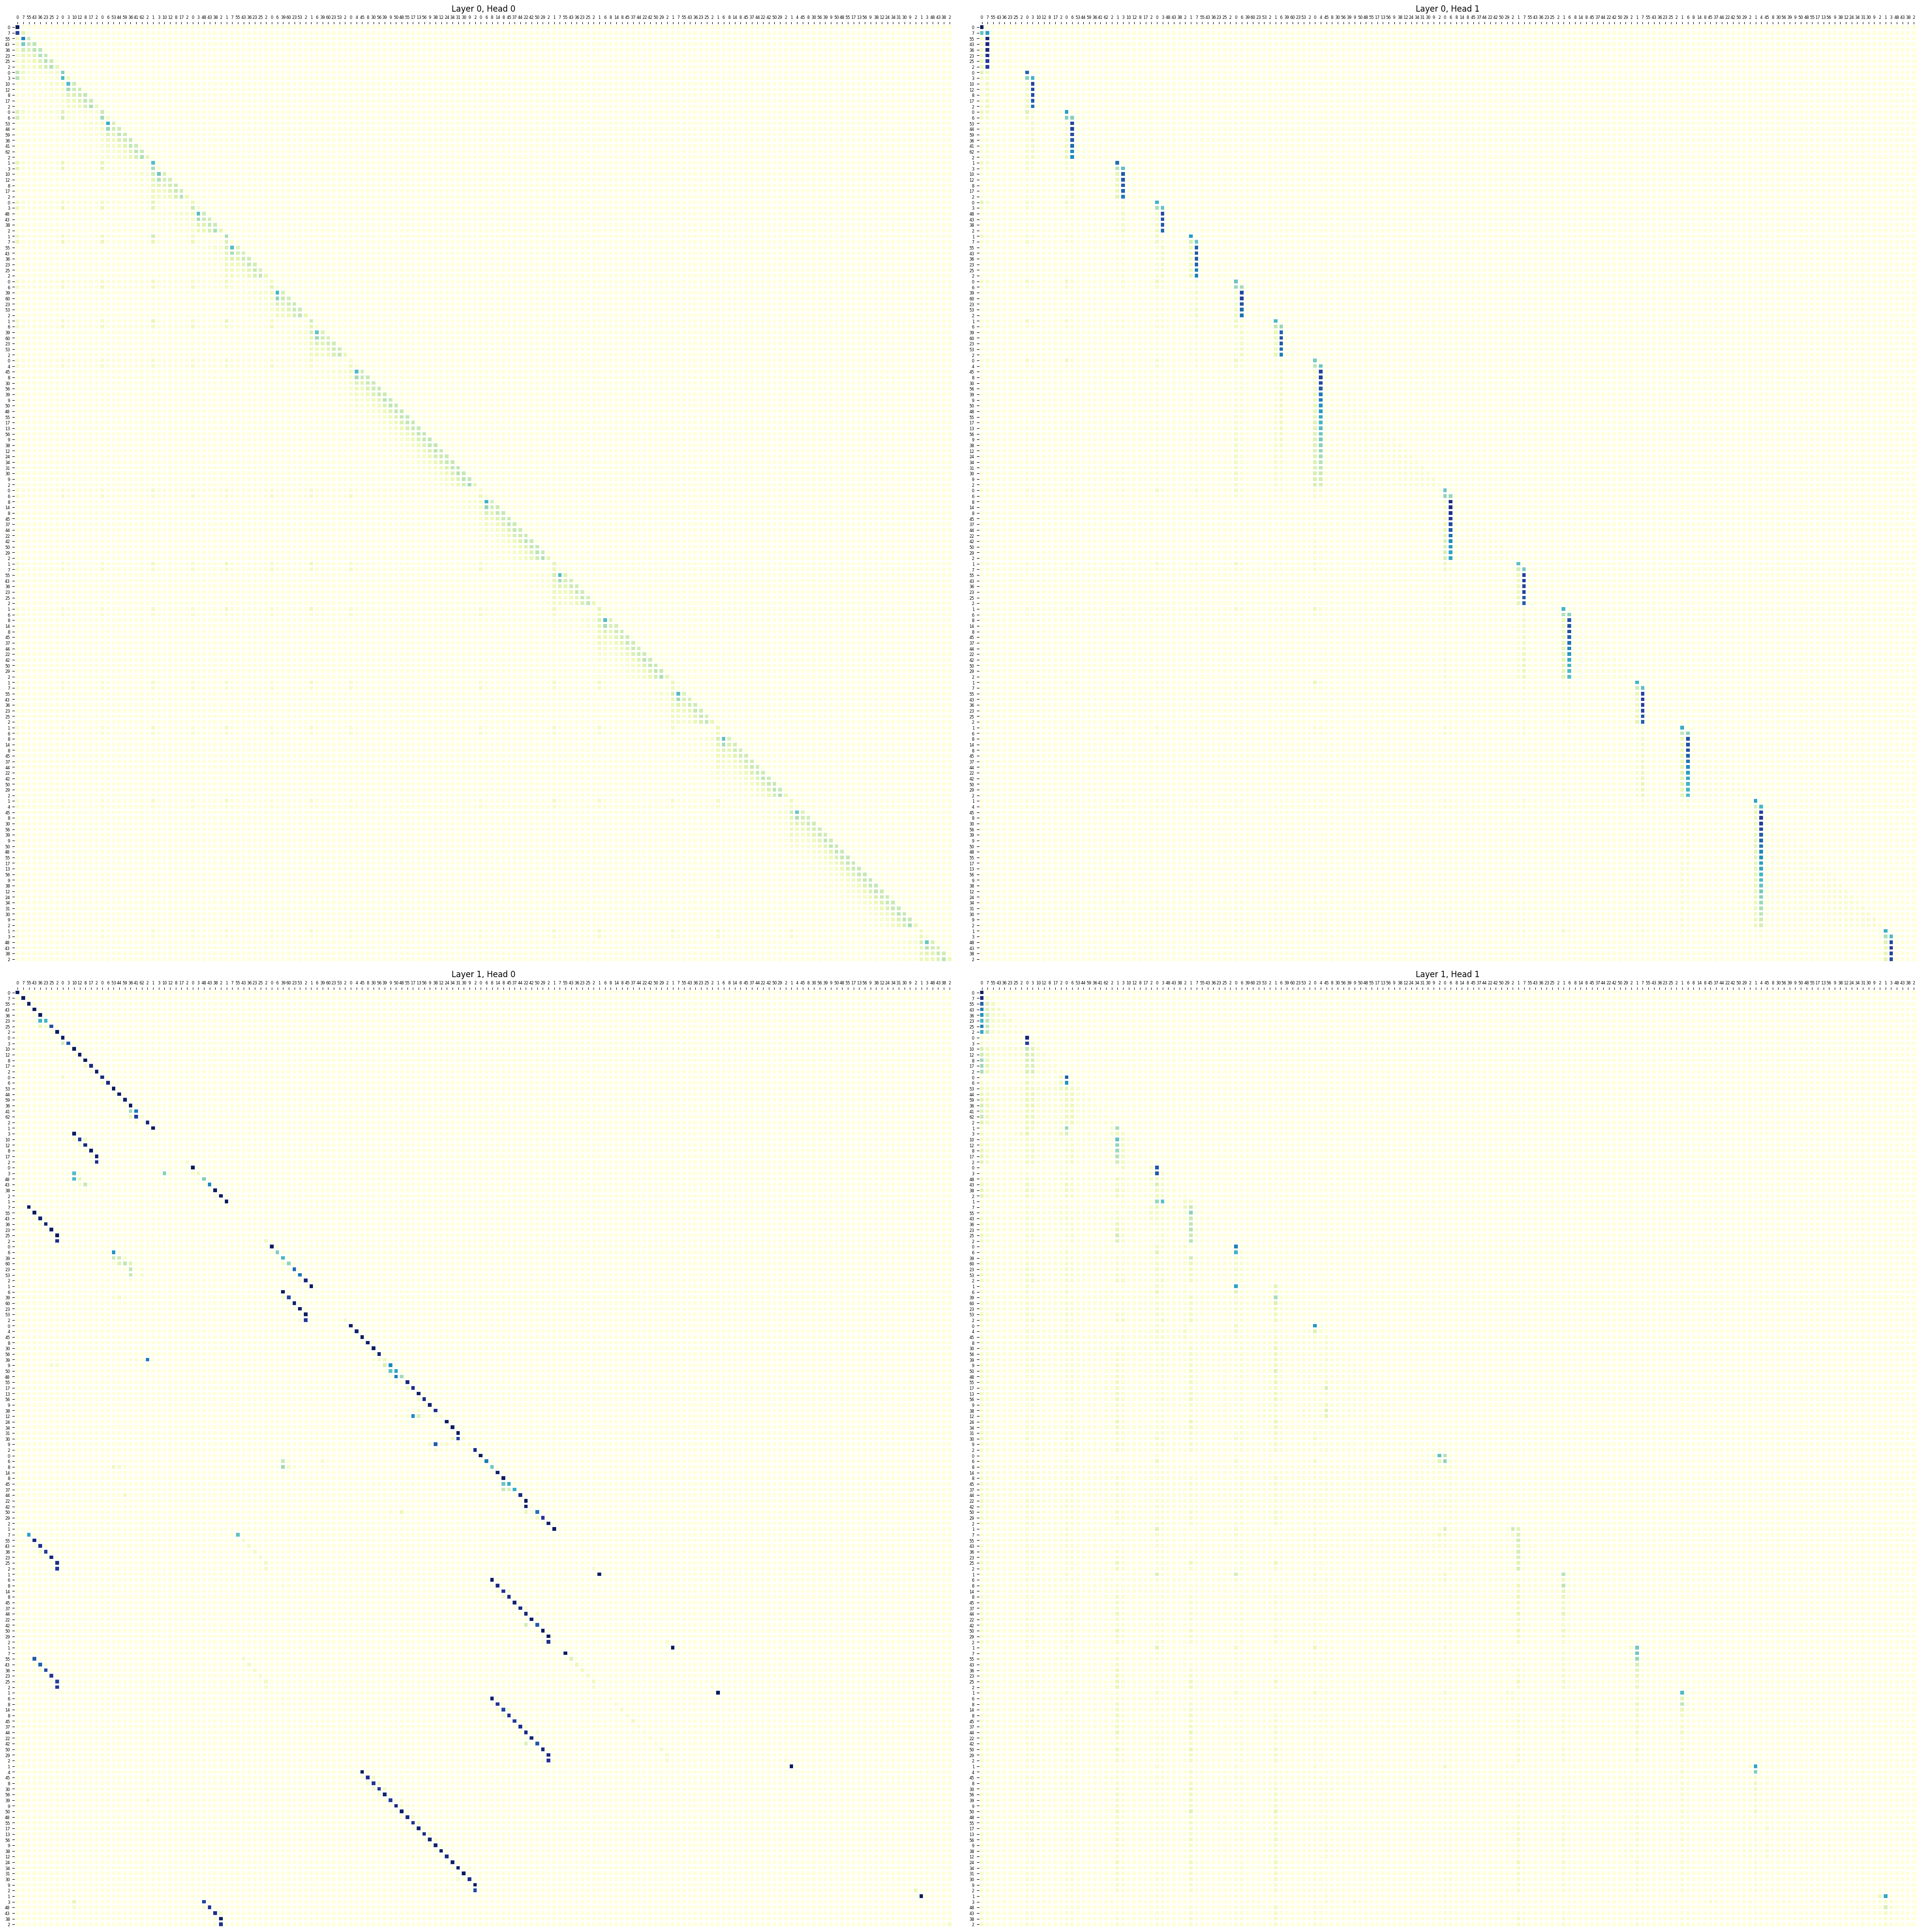

In [22]:
row_subset = jnp.arange(0, cursor)
col_subset = jnp.arange(0, cursor)

# Determine num_layers and num_heads from attn_weights structure
num_layers = len(attn_weights)
num_heads = attn_weights[0][0].shape[0]  # Assuming shape: [num_heads, seq, seq]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(20 * num_heads, 20 * num_layers), squeeze=False)

for l in range(num_layers):
    for h in range(num_heads):
        selected_attn = attn_weights[l][0][h][row_subset[:, None], col_subset[None, :]]
        ax = axes[l, h]
        im = heatmap(
            selected_attn,
            res[row_subset], res[col_subset], ax=ax,
            cmap="YlGnBu"
        )
        ax.set_title(f"Layer {l}, Head {h}")

fig.tight_layout()
plt.show()

In [23]:
res = jnp.array(res)
res[:cursor]

Array([ 0,  7, 55, 43, 36, 23, 25,  2,  0,  3, 10, 12,  8, 17,  2,  0,  6,
       53, 44, 59, 36, 41, 62,  2,  1,  3, 10, 12,  8, 17,  2,  0,  3, 48,
       43, 38,  2,  1,  7, 55, 43, 36, 23, 25,  2,  0,  6, 39, 60, 23, 53,
        2,  1,  6, 39, 60, 23, 53,  2,  0,  4, 45,  8, 30, 56, 39,  9, 50,
       48, 55, 17, 13, 56,  9, 38, 12, 24, 34, 31, 30,  9,  2,  0,  6,  8,
       14,  8, 45, 37, 44, 22, 42, 50, 29,  2,  1,  7, 55, 43, 36, 23, 25,
        2,  1,  6,  8, 14,  8, 45, 37, 44, 22, 42, 50, 29,  2,  1,  7, 55,
       43, 36, 23, 25,  2,  1,  6,  8, 14,  8, 45, 37, 44, 22, 42, 50, 29,
        2,  1,  4, 45,  8, 30, 56, 39,  9, 50, 48, 55, 17, 13, 56,  9, 38,
       12, 24, 34, 31, 30,  9,  2,  1,  3, 48, 43, 38,  2], dtype=int32)

---

# Component Identification

Given the adjacency list of a DAG consisting of several disconnected components and a start node (e.g. a leaf), return the root of its component. This is a global feature while the adjacency list only provides local features. Backtracking takes O(d) time where d is the max depth of a component, but this alone makes the problem difficult for a Transformer, which has fixed depth.
There are two approaches that would work but are just circumventing the interesting question:
1. Return the entire backtracking-path rather than just the root. So the compute scales over tokens rather than model depth.
2. Use a positional encoding for the DAG, creating a geometry which the Transformer can learn to query, essentially encoding distances between nodes in the input. This is kinda cheating, since it now makes querying for the root node constant time, since each node can query the farthest node from it that is reachable – the problem is solved implicitly in the definition of the positional encoding.
In particular, if the model architecture is parametric, so it adapts based on the graph depth, can we learn the right circuit for backtracking to the root of a component?

We can start by fixing the depth to a low value. We know depth 1 can be solved with a single induction head, since it merely reads the parent of each node in the adjacency list, which is the root. At depth 2, the model needs to query for the parent of each node's parent. The depth will then be logarithmic in the depth of the tree, since the distance the pointer covers doubles with each step.

Implementation:
Take as input EDGE PARENT CHILD EDGE PARENT CHILD ... EDGE PARENT CHILD.
Use causal attention but enforce the DAG – ensure a node can be a parent only if it has already been a child in the sequence thus far.
Exclude outputs for SEP and PARENT from the loss.
For all CHILD tokens have the root token as the target.
Each edge creates a local constraint: the nodes must be in the same component.
The root of a component is identified by the fact it has an edge to itself.
Also it is the first node to appear in an edge pair for its component.
To generate the data, create a few DAGs, create the edge pairs, then interleave them randomly.




364
21


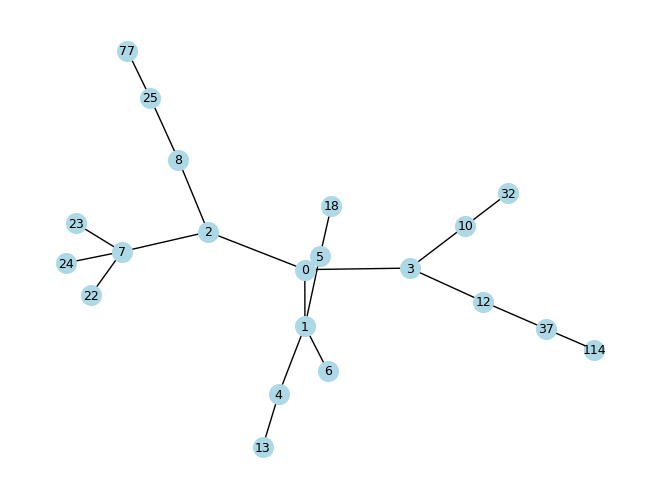

[(0, 2), (2, 7), (7, 24), (7, 23), (0, 3), (0, 1), (2, 8), (7, 22), (8, 25), (3, 12), (1, 6), (3, 10), (12, 37), (37, 114), (10, 32), (1, 4), (4, 13), (1, 5), (5, 18), (25, 77)]


In [95]:
def gen_dag_order(edge_list):
    random.shuffle(edge_list)

    # perform bubble sort on the edge list to enforce the DAG constraint
    unchanged = False
    while not unchanged:
        unchanged = True
        # assume edge tuples are (parent, child)
        for i in range(len(edge_list)):
            for j in range(i, len(edge_list)):
                if edge_list[i][0] == edge_list[j][1]: # i is before j but its parent is the same as j's child
                    edge_list[j], edge_list[i] = edge_list[i], edge_list[j] # swap them
                    unchanged = False

    return edge_list

def gen_tree(n_edges: int, r: int, h: int):
    # Create a balanced tree
    G = nx.balanced_tree(r=r, h=h)
    edge_list = list(G.edges())
    edge_list = gen_dag_order(edge_list)[:n_edges]
    G = nx.from_edgelist(edge_list)
    return G, edge_list

branching_factor = 3
height = 5 # = depth+1
n_nodes = sum(branching_factor**i for i in range(height+1))
print(n_nodes)
G, edge_list = gen_tree(20, branching_factor, height)
print(len(G.nodes()))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=200, font_size=9, node_color='lightblue', pos=pos)
plt.show()

print(edge_list)

---

# Path Graph

## Problem

Given a 'goal' token, identify which unique 'path' in context it comes from and return all tokens in the path up to and including the goal.

Concretely, suppose your context has two paths: A,B,C and P,Q,R,S. Given a goal R, we would return P,Q,R. This tests the model's ability to build pointers between tokens based on context.

## Dataset Generation

The dataset consists of a list of sequences. Sequences can be one of three types:
- context
- input
- output

No nesting of sequences is allowed.

#### Tokenization

Overall will use 128 tokens.

Special Tokens (with index):
- Context Start: 0
- Input Start: 1
- Output start: 2

Each special token implicitly ends the previous sequence and starts a new one. These embeddings can be learned.

All remaining tokens are exchangeable, i.e. only act as pointers and contain no semantic meaning. Their embeddings will be fixed and initialized randomly.

1. Minimal example
- 0, 3,4,5,6, 1, 5, 2, 3,4,5

2. Two contexts
- 0, 3,4,5,6, 0, 7,8,9, 1, 4, 2, 3,4

3. Stream of problems (context grows and problems arrive independently)
- 0, 3,4,5,6, 0, 7,8,9, 1, 5, 2, 3,4,5, 0, 10,11,12,13,14, 1, 4, 2, 3,4, 1, 12, 2, 10,11,12

For position encoding we'll use RoPE which works well with QK-norm attention.

In [24]:
# TBD, need to add masking to loss_fn()!